In [19]:
import numpy as np 
from matplotlib import pyplot as plt 
import torch
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from scipy import signal
from scipy.stats import pearsonr
import yaml
from tqdm.notebook import tqdm

In [20]:
def load_yaml(yaml_file):
    ''' 
    Function to load yaml file

    Args:
        yaml_file (str): File path 
    Returns:
        data (dict): Returns loaded yaml file as dictionary
    '''
    with open(yaml_file,'r') as file:
        data = yaml.safe_load(file)
    return data


def cal_gausswt(n_lat, rad, A, epsilon):
    ''' 
    Args:
        n_lat (int): Number of lateral connections
        rad (float): Radius of the gaussian
        A (float): Depth parameter
        epsilon (float): positive Offset
    Returns:
        weight(np.ndarray): Gaussian weights of shape (n_lat**2, n_lat, n_lat)
    Return Gaussian weigths for all neurons
    '''
    wt = np.zeros((n_lat, n_lat, n_lat, n_lat))

    for i in range(n_lat):
        for j in range(n_lat):
            for m in range(n_lat):
                for n in range(n_lat):
                    dist = (i - m)**2 + (j - n)**2

                    if np.sqrt(dist) < rad:
                        wt[i][j][m][n] = epsilon - A * np.exp(-dist/rad**2)

                    
                    if np.sqrt(dist) ==0:
                        wt[i][j][m][n] = 1
                   
    weight = np.reshape(wt,(n_lat**2, n_lat,n_lat))
    return weight


def gauss_sum(wt, arr):
    ''' 
    Args:
        wt (np.ndarray): weight array
        arr (np.ndarray): array
    
    Returns:
        final_values (np.ndarray): Pdt of wt, arr
    '''
    num_neurons = wt.shape[0]
    grid_size = wt.shape[1]
    pdt = np.zeros(num_neurons)
    for neuron in range(num_neurons):
        pdt[neuron] = np.sum(wt[neuron] * arr)
    final_values = pdt.reshape(grid_size,grid_size)
    return final_values

def gauss_weights(n_lat, rad, A1, A2, sigma1, sigma2, epsilon):
    wt = np.zeros((n_lat, n_lat, n_lat, n_lat))

    for i in range(n_lat):
        for j in range(n_lat):
            for m in range(n_lat):
                for n in range(n_lat):
                    dist = (i - m)**2 + (j - n)**2
                    if np.sqrt(dist) < rad:
                        gauss_1 = A1 * np.exp(-dist/sigma1**2)
                        gauss_2 = A2 * np.exp(-dist/sigma2**2)
                        wt[i][j][m][n] = -epsilon * (gauss_1 -gauss_2)
                    
                    if dist ==0:
                        wt[i][j][m][n] = 1

    weight = np.reshape(wt,(n_lat**2, n_lat,n_lat))
                    
    return weight

In [21]:
#weight = cal_gausswt(n_lat = 20, rad= 2, A = 0.1, epsilon = 0.05)
weight = cal_gausswt(n_lat = 20, rad = 3, A = 0.3, epsilon = 0.0)

In [22]:
def STN_GPe_osc(yaml_path):
    arguments = load_yaml(yaml_path)
    n = arguments.get('n')
    N = n**2
        
    # Gaussian params:

    A1 = arguments.get('A1')
    A2 = arguments.get('A2')
    sigma1 = arguments.get('sigma1')
    sigma2 = arguments.get('sigma2')
    ep = arguments.get('ep')
    rad = arguments.get('rad')
    A = arguments.get('A')
    w_lat_gpe = cal_gausswt(n_lat = n, rad = rad, A = A, epsilon = ep)

    # Network params:
    lambda_gpe = arguments.get('lambda_gpe') # parameter for u_gpe
    A_gpe = arguments.get('A_gpe')
    
    tau_gpe = arguments.get('tau_gpe')
    tau_stn = arguments.get('tau_stn')
    I_DAmultiplier = arguments.get('I_DAmultiplier')
    # Error correction
    tau = arguments.get('tau')
    lambda_g = arguments.get('lambda_g')
    DA = arguments.get('DA')

    time = arguments.get('time')
    dt = arguments.get('dt')

    # Initialisation
    x_gpe = np.random.uniform(-1,1,(n,n)) #np.zeros((n,n))
    u_gpe = np.tanh(lambda_gpe * x_gpe)
    x_stn = np.random.uniform(-1,1,(n,n)) #np.zeros((n,n))
    I_gpe = A_gpe * np.random.uniform(-1,1,(n,n))
    E = 0
    I_DA = 0
    e = 0

    # Monitor for storing values
    u_gpe_monitor = {}
    x_gpe_monitor = {}
    x_gpe_single = []
    u_gpe_single = []
    x_stn_single = []
    x_stn_monitor = {}
    v_tot_mon = []
    E_mon = []
    e_mon = []
    I_DA_mon = []
    u_gpe_sing = []
    u_gpe_mon = []

    for i in tqdm(range(time)):
        I_gpe = A_gpe * np.random.uniform(-1,1,(n,n))
        pdt_val =  gauss_sum(wt = w_lat_gpe, arr = u_gpe)
        dx_gpe_dt = -x_gpe + pdt_val + x_stn + I_gpe + (I_DA * I_DAmultiplier) + arguments.get('p_gain') * e
        x_gpe = x_gpe + (dt/tau_gpe) * (dx_gpe_dt)
        u_gpe = np.tanh(lambda_gpe * x_gpe)
        dx_stn_dt = -x_stn - u_gpe
        x_stn = x_stn + (dt/tau_stn) * (dx_stn_dt)
        
        v_tot = 0.5 * np.sum(u_gpe + 1)
        e = DA - v_tot 
        
        dE_dt = np.tanh(lambda_g * e)/tau 
        E = E + dt * dE_dt 
        
        I_DA = E - (N/2)

        u_gpe_monitor[i] = u_gpe
        x_gpe_monitor[i] = x_gpe
        x_stn_monitor[i] = x_stn
        E_mon.append(E)
        I_DA_mon.append(I_DA)
        e_mon.append(e)
        v_tot_mon.append(v_tot)
        x_gpe_single.append(x_gpe[10][8])
        u_gpe_single.append(u_gpe[10][8])
        x_stn_single.append(x_stn[10][8])
        u_gpe_mon.append(u_gpe)
    return u_gpe_monitor, x_gpe_monitor, x_stn_monitor, E_mon, I_DA_mon, e_mon, v_tot_mon, x_gpe_single, u_gpe_single, x_stn_single,u_gpe_mon 

In [23]:
yaml_path = r'D:\CNS IITM\Spiking Neurons\params.yaml'
u_gpe_monitor, x_gpe_monitor, x_stn_monitor, E_mon, I_DA_mon, e_mon, v_tot_mon, x_gpe_single, u_gpe_single, x_stn_single,u_gpe_mon = STN_GPe_osc(yaml_path)

  0%|          | 0/5000 [00:00<?, ?it/s]

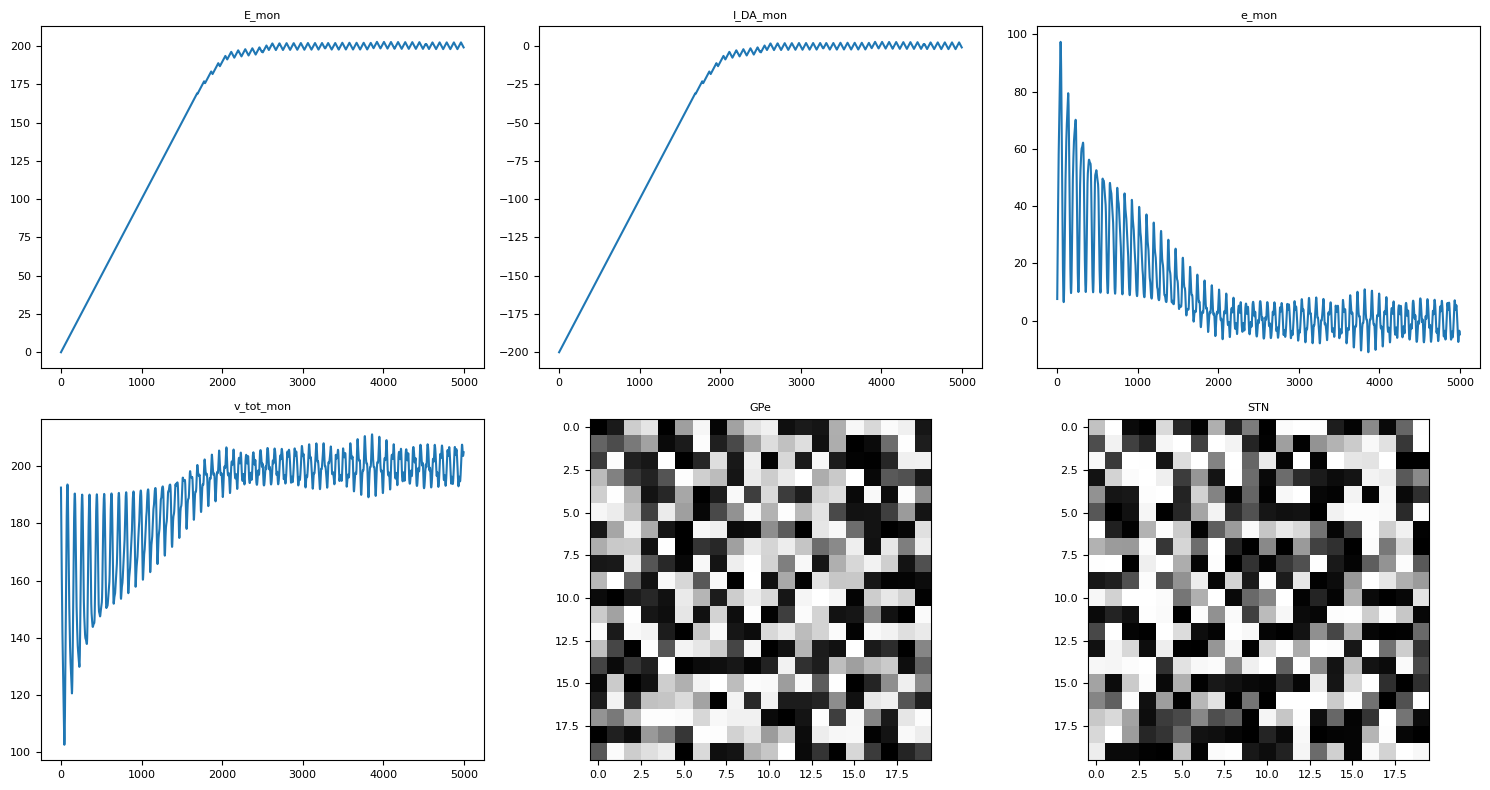

In [24]:
plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
plt.plot(E_mon)
plt.title('E_mon', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.subplot(2,3,2)
plt.plot(I_DA_mon)
plt.title('I_DA_mon', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.subplot(2,3,3)
plt.plot(e_mon)
plt.title('e_mon', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.subplot(2,3,4)
plt.plot(v_tot_mon)
plt.title('v_tot_mon', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.subplot(2,3,5)
plt.imshow(u_gpe_monitor[2810],cmap = 'gray')
plt.title('GPe', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.subplot(2,3,6)
plt.imshow(x_stn_monitor[2000], cmap = 'gray')
plt.title('STN', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
           
plt.tight_layout()

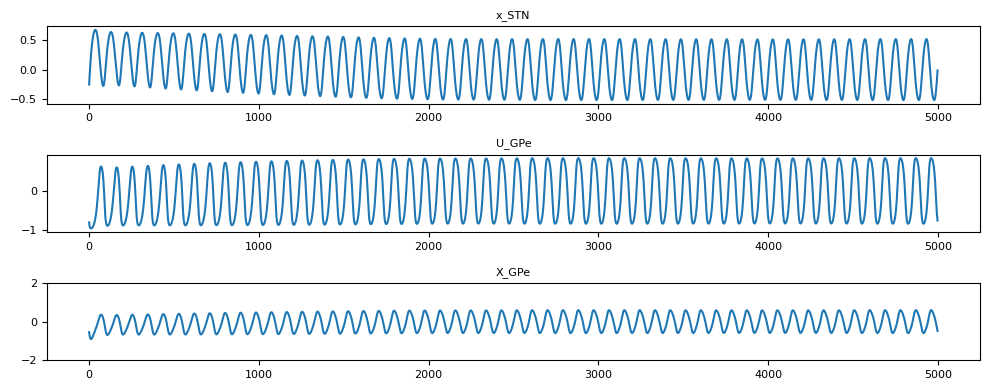

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(3,1,1)
plt.plot(x_stn_single)
plt.title('x_STN', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
#plt.xlim(1000,2000)

plt.subplot(3,1,2)
plt.plot(u_gpe_single)
plt.title('U_GPe', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.subplot(3,1,3)
plt.plot(x_gpe_single)
plt.title('X_GPe', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.ylim(-2,2)

plt.tight_layout()
plt.show()

In [26]:
np.array(u_gpe_mon).shape

(5000, 20, 20)

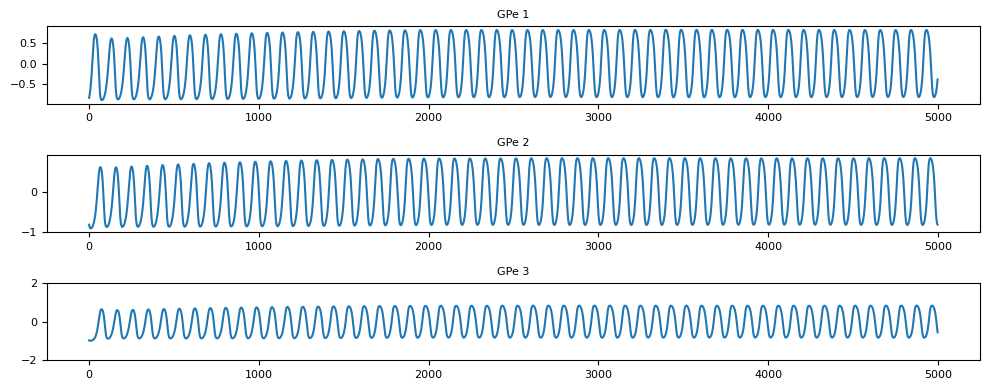

In [27]:
u_gpe_mon = np.array(u_gpe_mon)
plt.figure(figsize=(10,4))
plt.subplot(3,1,1)
plt.plot(u_gpe_mon[:,15,15])
plt.title('GPe 1', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
#plt.xlim(1000,2000)

plt.subplot(3,1,2)
plt.plot(u_gpe_mon[:,1,9])
plt.title('GPe 2', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.subplot(3,1,3)
plt.plot(u_gpe_mon[:,11,5])
plt.title('GPe 3', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.ylim(-2,2)

plt.tight_layout()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


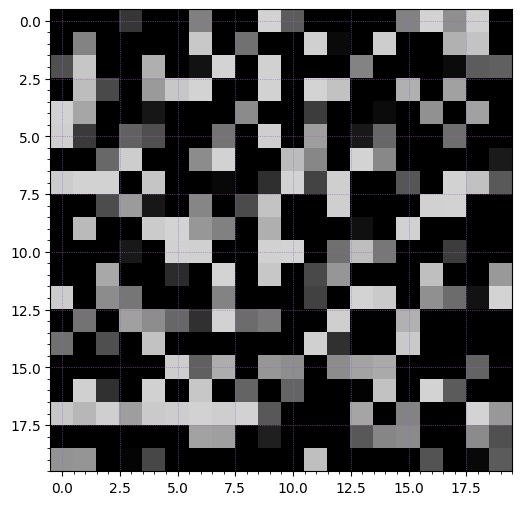

In [28]:
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
! mkdir images
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1, 1, 1)
t = np.arange(4000,5000,10)
camera = Camera(fig)
for i in t:
    ax.grid(which='major', color='#9467bd', linestyle=':', linewidth=0.5)
    plt.grid(color='#9467bd', linestyle=':')
    
    ax.minorticks_on()
    plt.imshow(u_gpe_monitor[i], cmap = 'gray', vmin=0, vmax=1)
    
    camera.snap()
animation = camera.animate()

animation.save('animation_init.gif')

In [29]:
'''
u_gpe_mon = np.array(u_gpe_mon)
u_gpe_mon = u_gpe_mon.reshape(u_gpe_mon.shape[0],u_gpe_mon.shape[1]**2)
print(u_gpe_mon.shape)
correlation_array = []

for i in range(400):
    for j in range(400):
        arr_1 = u_gpe_mon[:,i]
        arr_2 = u_gpe_mon[:,j]
        corr, _ = pearsonr(arr_1, arr_2)
        correlation_array.append(corr)
print(f'Average correlation = {np.mean(np.array(correlation_array))}')
'''

"\nu_gpe_mon = np.array(u_gpe_mon)\nu_gpe_mon = u_gpe_mon.reshape(u_gpe_mon.shape[0],u_gpe_mon.shape[1]**2)\nprint(u_gpe_mon.shape)\ncorrelation_array = []\n\nfor i in range(400):\n    for j in range(400):\n        arr_1 = u_gpe_mon[:,i]\n        arr_2 = u_gpe_mon[:,j]\n        corr, _ = pearsonr(arr_1, arr_2)\n        correlation_array.append(corr)\nprint(f'Average correlation = {np.mean(np.array(correlation_array))}')\n"